# Entrenamiento de Clasificador basado en Embeddings y Etiquetas CLIP

Este notebook entrena un clasificador usando:
1. **Embeddings** extraídos con ResNet50 (del pipeline principal)
2. **Etiquetas** generadas por CLIP (del notebook `frame_labeling_clip.ipynb`)

**Objetivo:**
- Entrenar una cabeza de clasificación que use los embeddings de ResNet50 como features
- Predecir las categorías de CLIP (person, logo, table, candlestick, etc.)
- Evaluar el desempeño del modelo entrenado



## Configuración Inicial


In [1]:
#pip install autogluon


In [3]:
import sys
import os
from pathlib import Path

# Configurar paths
project_root = Path("/Users/andrestrepo/Documents/repos_personal/proyecto-vision-computador")
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / "src"))

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# AutoGluon
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Feature extractor para cargar embeddings
from src.app.utils.feature_extractor import FeatureExtractor

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


## 1. Cargar Dataset Etiquetado por CLIP


In [23]:
# Cargar dataset etiquetado por CLIP y OpenAI
CLIP_OPEN_IA_LABELED_DATASET = "datasets/df_frames_openai_labeled_v4.csv"

if not os.path.exists(CLIP_OPEN_IA_LABELED_DATASET):
    raise FileNotFoundError(
        f"Dataset etiquetado por CLIP no encontrado: {CLIP_OPEN_IA_LABELED_DATASET}\n"
        f"Ejecuta primero el notebook 'frame_labeling_clip.ipynb' para generar las etiquetas."
    )

df_clip = pd.read_csv(CLIP_OPEN_IA_LABELED_DATASET)

print(f"✅ Dataset CLIP y OpenAI cargado: {len(df_clip):,} frames")
print(f"   Columnas: {df_clip.columns.tolist()}")

# Filtrar solo frames donde CLIP y OpenAI están de acuerdo (misma categoría)
# EXCEPCIÓN: Para "other" mantener solo los frames que OpenAI etiquetó como "other"
print(f"\n🔍 Filtrando frames donde CLIP y OpenAI están de acuerdo...")
print(f"   (Excepción: categoría 'other' - solo frames etiquetados por OpenAI como 'other')")

# Verificar que ambas columnas existen y no son nulas
df_clip_valid = df_clip[
    df_clip['clip_category_code'].notna() & 
    df_clip['openai_category_code'].notna()
].copy()

# Separar frames donde OpenAI dice "other" y el resto
df_other_openai = df_clip_valid[df_clip_valid['openai_category_code'] == 'other'].copy()
df_not_other = df_clip_valid[df_clip_valid['openai_category_code'] != 'other'].copy()

# Para categorías distintas de "other", filtrar donde ambas categorías coinciden
df_agreement = df_not_other[
    df_not_other['clip_category_code'] == df_not_other['openai_category_code']
].copy()

# Para los frames de "other" de OpenAI, usar la etiqueta de OpenAI
df_other_openai['clip_category_code'] = 'other'  # Asegurar que usamos "other" como etiqueta

# Combinar: frames con acuerdo (excepto other) + frames de other etiquetados por OpenAI
df_final = pd.concat([df_agreement, df_other_openai], ignore_index=True)

print(f"   Frames originales: {len(df_clip):,}")
print(f"   Frames con etiquetas válidas (CLIP y OpenAI): {len(df_clip_valid):,}")
print(f"   Frames de 'other' etiquetados por OpenAI: {len(df_other_openai):,}")
print(f"   Frames de otras categorías con acuerdo: {len(df_agreement):,}")
print(f"   Frames descartados (sin acuerdo, excluyendo 'other'): {len(df_not_other) - len(df_agreement):,} ({((len(df_not_other) - len(df_agreement)) / len(df_not_other) * 100):.1f}%)")
print(f"   Total frames finales: {len(df_final):,}")

# Usar el dataset filtrado
df_clip = df_final

print(f"\n📊 Distribución de categorías (después del filtro de acuerdo):")
category_counts = df_clip['clip_category_code'].value_counts()
for cat, count in category_counts.items():
    pct = count / len(df_clip) * 100
    print(f"   {cat:15s}: {count:6,} frames ({pct:5.2f}%)")


✅ Dataset CLIP y OpenAI cargado: 10,000 frames
   Columnas: ['video_id', 'channel', 'video_date', 'video_filename', 'duration', 'frame_path', 'n_frames_original', 'n_frames_filtrado', 'reduction_percentage', 'clip_category_idx', 'clip_category_code', 'clip_category_text', 'clip_score', 'openai_category_code', 'openai_category_text', 'openai_raw_response', 'openai_error']

🔍 Filtrando frames donde CLIP y OpenAI están de acuerdo...
   (Excepción: categoría 'other' - solo frames etiquetados por OpenAI como 'other')
   Frames originales: 10,000
   Frames con etiquetas válidas (CLIP y OpenAI): 10,000
   Frames de 'other' etiquetados por OpenAI: 24
   Frames de otras categorías con acuerdo: 3,645
   Frames descartados (sin acuerdo, excluyendo 'other'): 6,331 (63.5%)
   Total frames finales: 3,669

📊 Distribución de categorías (después del filtro de acuerdo):
   candlestick    :  1,011 frames (27.56%)
   person         :    698 frames (19.02%)
   line_chart     :    443 frames (12.07%)
   tab

## 1.1 Visualizar Muestras por Categoría

Visualizamos algunas muestras de cada categoría para verificar la calidad de las etiquetas.


In [24]:
from PIL import Image

def show_category_samples(df_clip, category_code, n_samples=8, min_score=None):
    """
    Muestra muestras representativas de una categoría.
    
    Args:
        df_clip: DataFrame con frames etiquetados
        category_code: Código de la categoría a mostrar
        n_samples: Número de muestras a mostrar
        min_score: Score mínimo (opcional, ya debería estar filtrado)
    """
    category_frames = df_clip[df_clip['clip_category_code'] == category_code].copy()
    
    # Filtrar por score si se especifica
    if min_score is not None:
        category_frames = category_frames[category_frames['clip_score'] >= min_score]
    
    if len(category_frames) == 0:
        print(f"⚠️  No hay frames en la categoría '{category_code}'")
        return None
    
    # Seleccionar muestras aleatorias
    samples = category_frames.sample(min(n_samples, len(category_frames))).to_dict('records')
    
    # Crear visualización
    n_cols = min(4, len(samples))
    n_rows = (len(samples) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1) if n_cols > 1 else np.array([axes])
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    for idx, sample in enumerate(samples):
        row = idx // n_cols
        col = idx % n_cols
        
        if n_rows == 1:
            ax = axes[col] if isinstance(axes, np.ndarray) else axes[0, col]
        else:
            ax = axes[row, col]
        
        try:
            frame_path = sample['frame_path']
            if os.path.exists(frame_path):
                img = Image.open(frame_path)
                ax.imshow(img)
                ax.axis('off')
                
                title = f"Score: {sample['clip_score']:.3f}"
                if 'video_id' in sample:
                    title += f"\nVideo: {sample['video_id'][:8]}..."
                ax.set_title(title, fontsize=10)
            else:
                ax.text(0.5, 0.5, f"Imagen no encontrada\n{frame_path}", 
                       ha='center', va='center', fontsize=8)
                ax.axis('off')
        except Exception as e:
            ax.text(0.5, 0.5, f"Error: {str(e)}", ha='center', va='center')
            ax.axis('off')
    
    # Ocultar ejes vacíos
    for idx in range(len(samples), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        if n_rows == 1:
            axes[col].axis('off')
        else:
            axes[row, col].axis('off')
    
    plt.suptitle(f"Categoría: {category_code} ({len(category_frames)} frames totales)", 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return category_frames



🖼️  Visualizando muestras por categoría...

📊 Categoría: candlestick
   Total frames: 1,011
   Score promedio: 0.260
   Score mínimo: 0.204
   Score máximo: 0.312


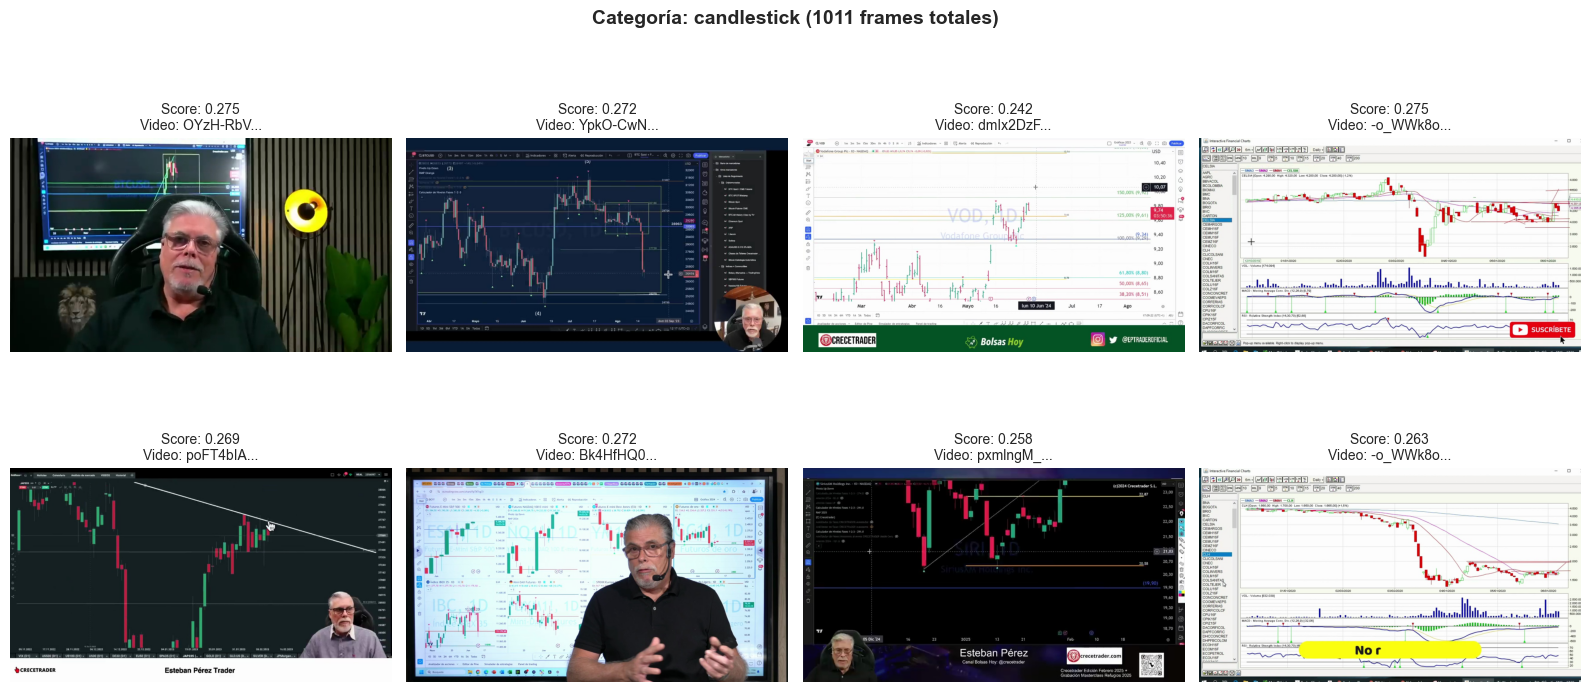

--------------------------------------------------------------------------------

📊 Categoría: person
   Total frames: 698
   Score promedio: 0.244
   Score mínimo: 0.203
   Score máximo: 0.291


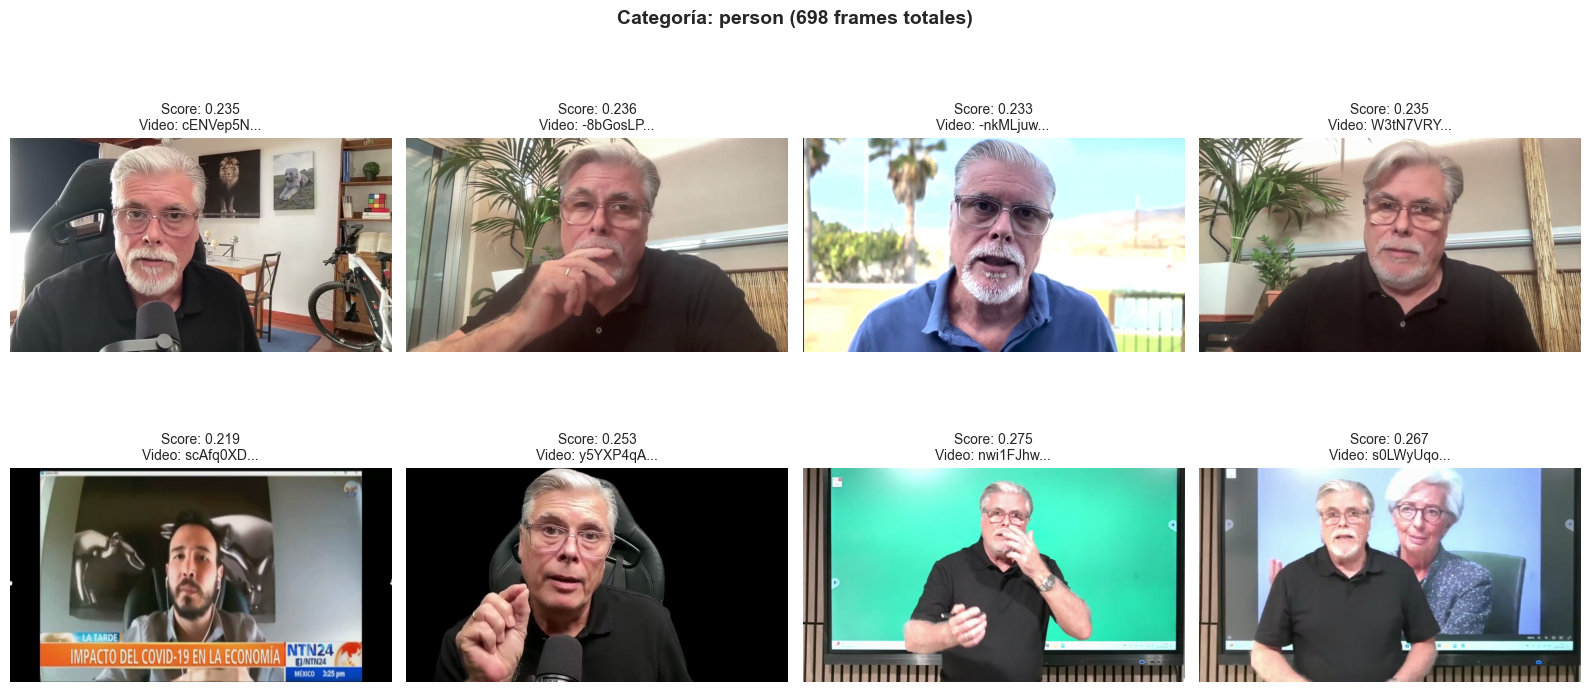

--------------------------------------------------------------------------------

📊 Categoría: line_chart
   Total frames: 443
   Score promedio: 0.253
   Score mínimo: 0.203
   Score máximo: 0.293


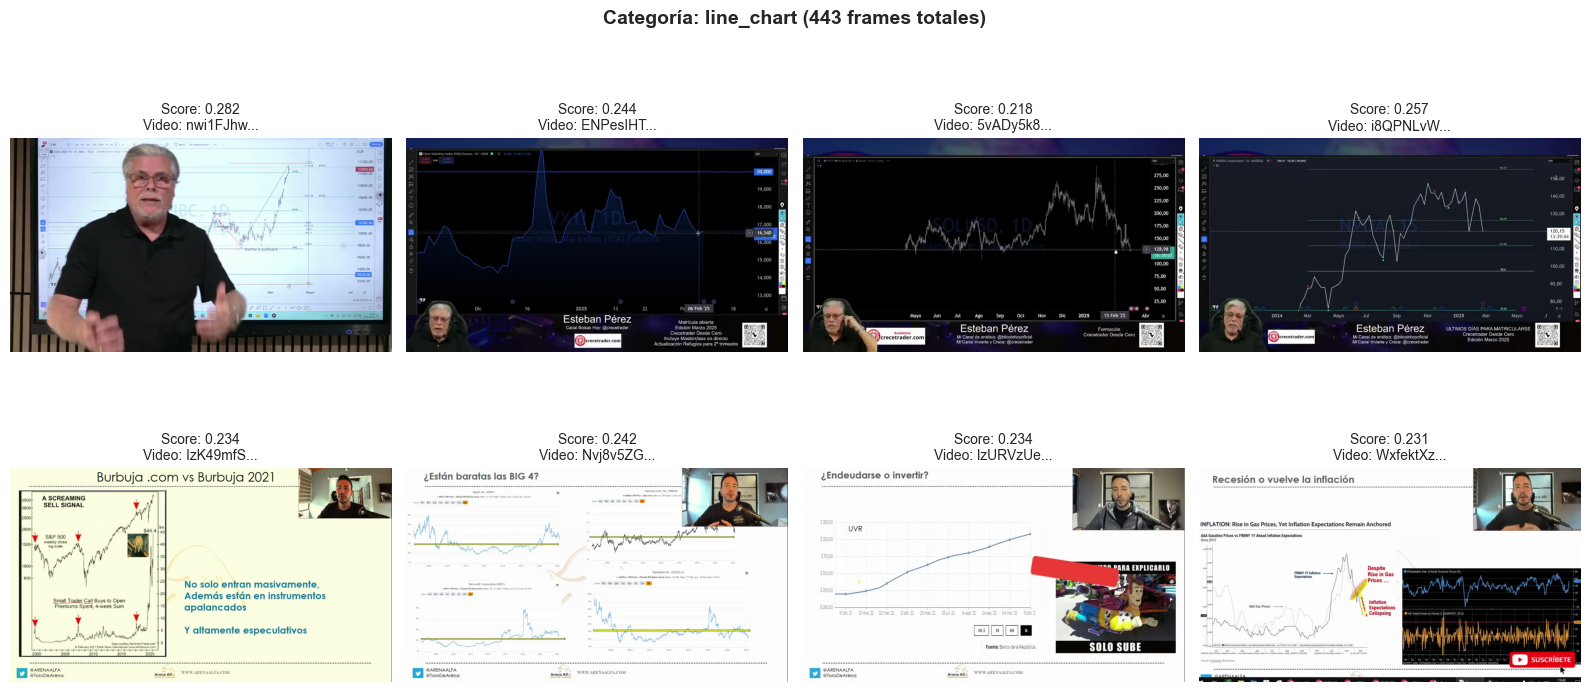

--------------------------------------------------------------------------------

📊 Categoría: table
   Total frames: 398
   Score promedio: 0.263
   Score mínimo: 0.215
   Score máximo: 0.325


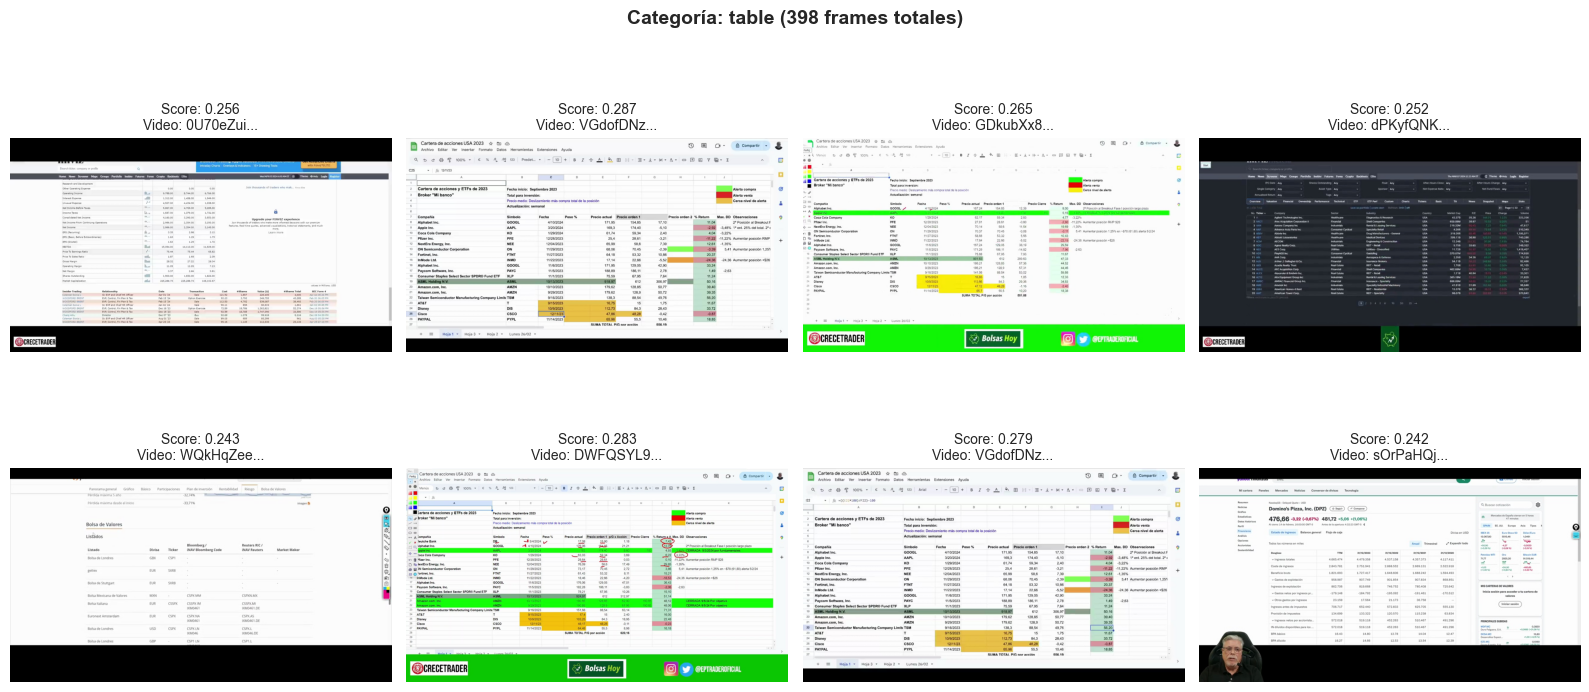

--------------------------------------------------------------------------------

📊 Categoría: text
   Total frames: 365
   Score promedio: 0.245
   Score mínimo: 0.203
   Score máximo: 0.292


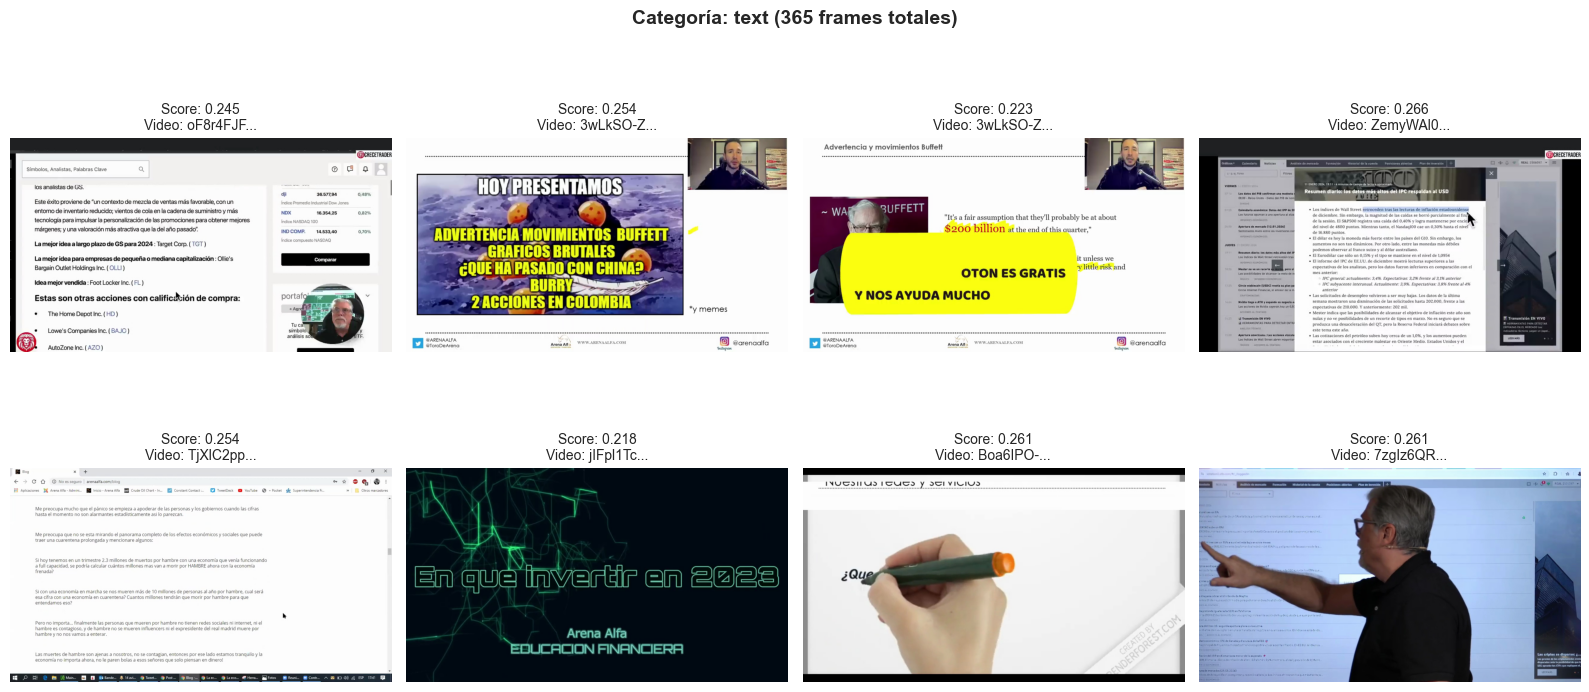

--------------------------------------------------------------------------------

📊 Categoría: logo
   Total frames: 180
   Score promedio: 0.231
   Score mínimo: 0.205
   Score máximo: 0.270


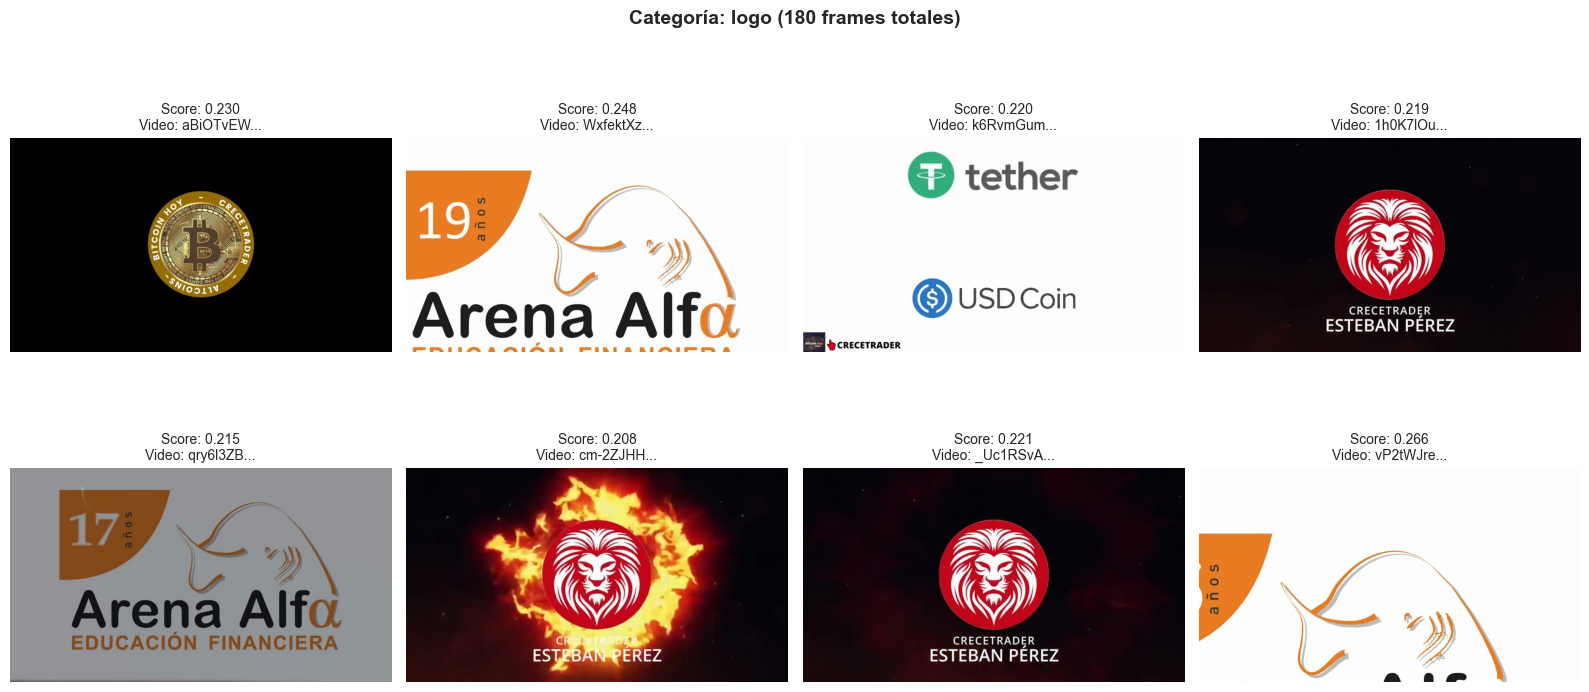

--------------------------------------------------------------------------------

📊 Categoría: screenshot
   Total frames: 170
   Score promedio: 0.262
   Score mínimo: 0.211
   Score máximo: 0.307


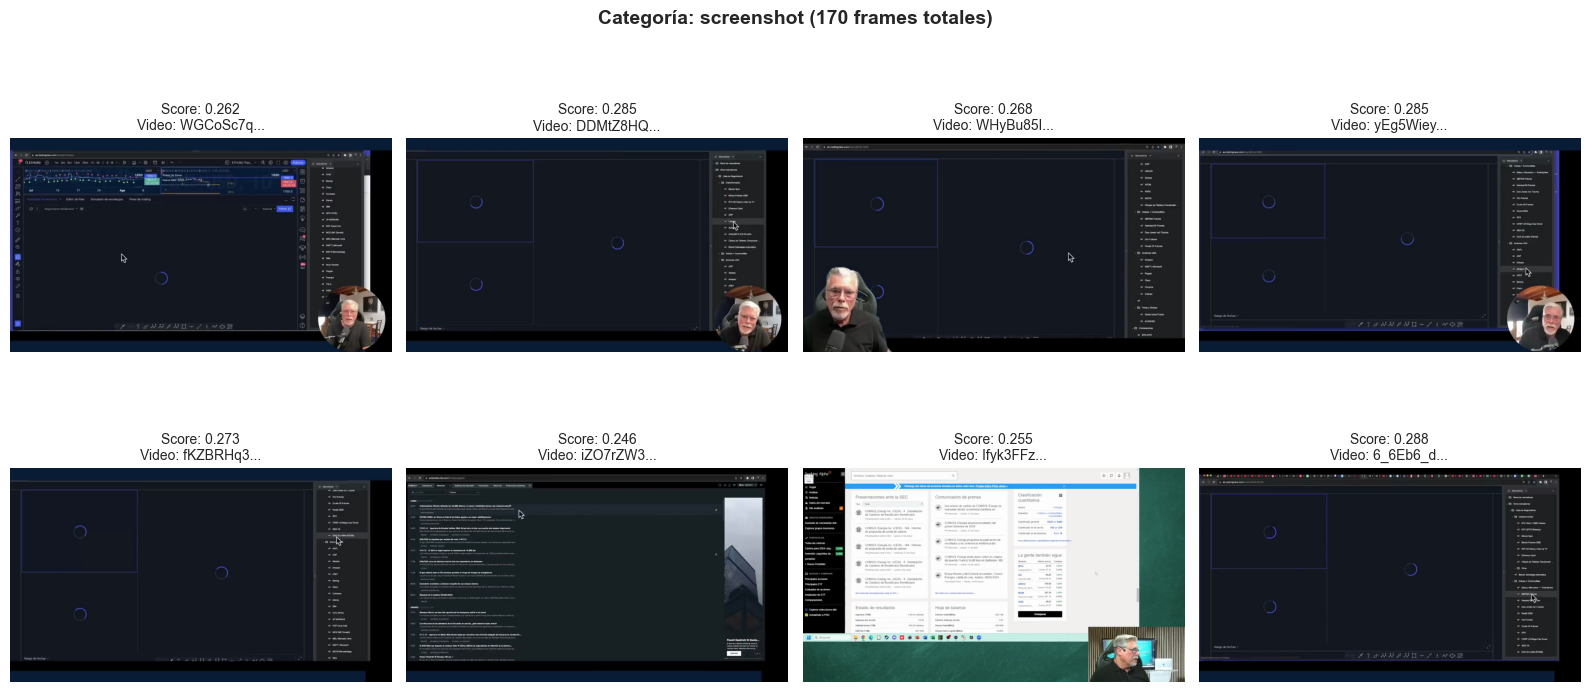

--------------------------------------------------------------------------------

📊 Categoría: bar_chart
   Total frames: 166
   Score promedio: 0.245
   Score mínimo: 0.211
   Score máximo: 0.290


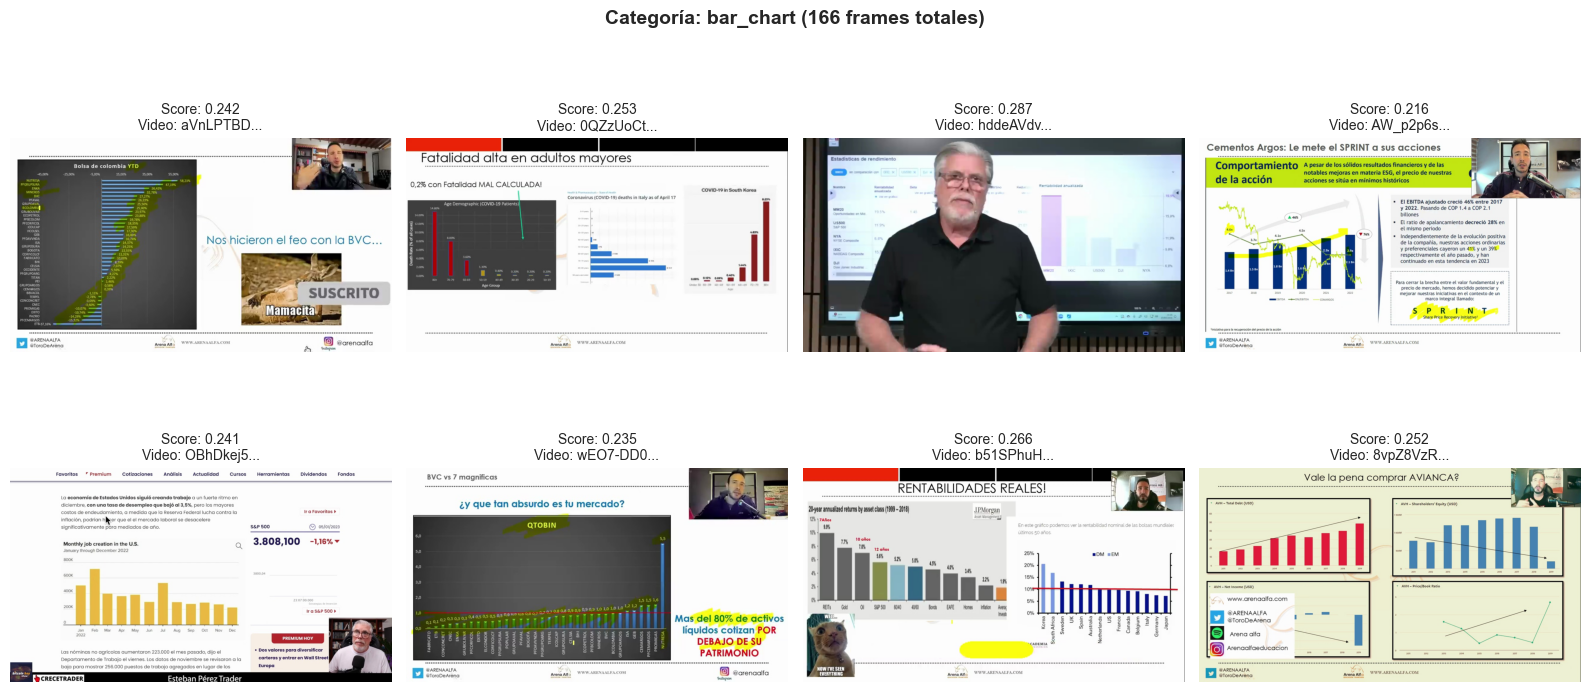

--------------------------------------------------------------------------------

📊 Categoría: diagram
   Total frames: 118
   Score promedio: 0.249
   Score mínimo: 0.220
   Score máximo: 0.274


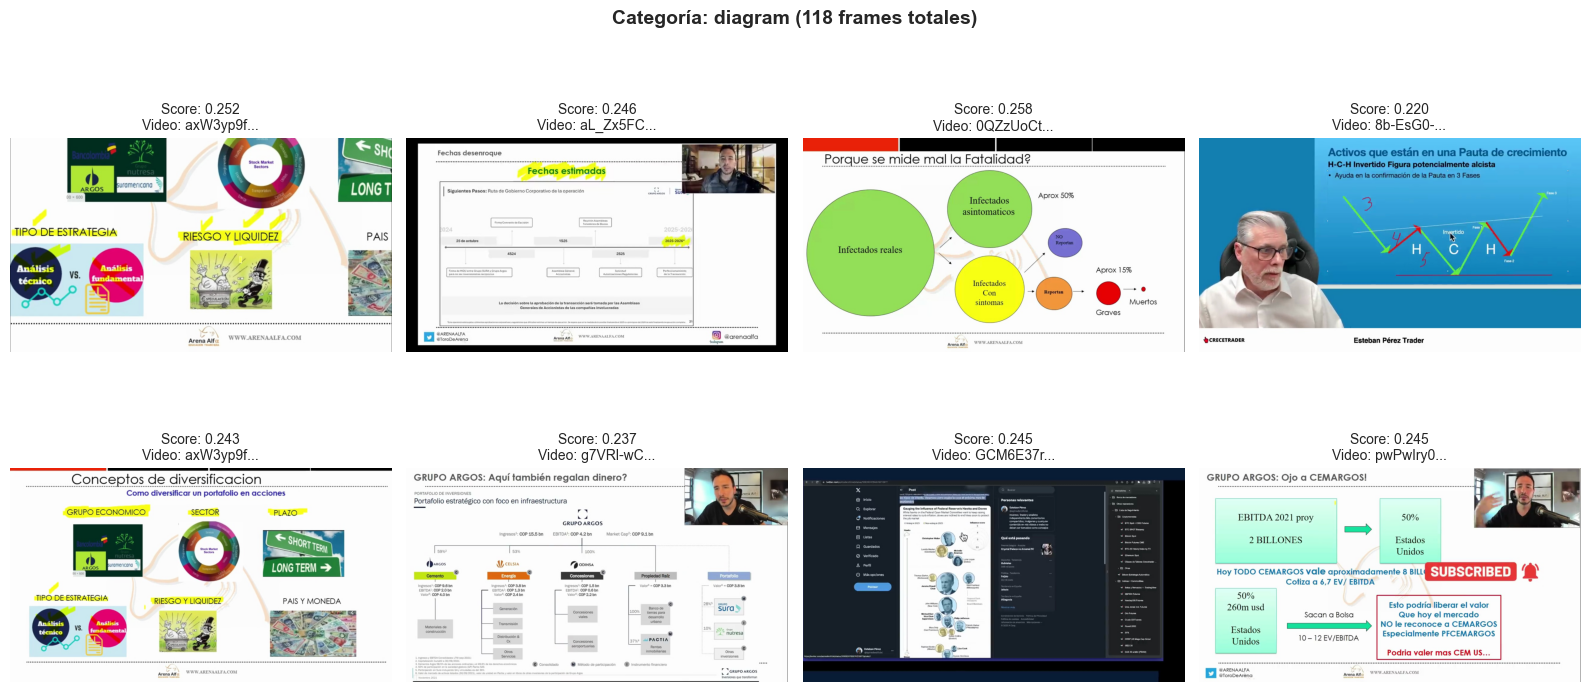

--------------------------------------------------------------------------------

📊 Categoría: background
   Total frames: 96
   Score promedio: 0.262
   Score mínimo: 0.238
   Score máximo: 0.286


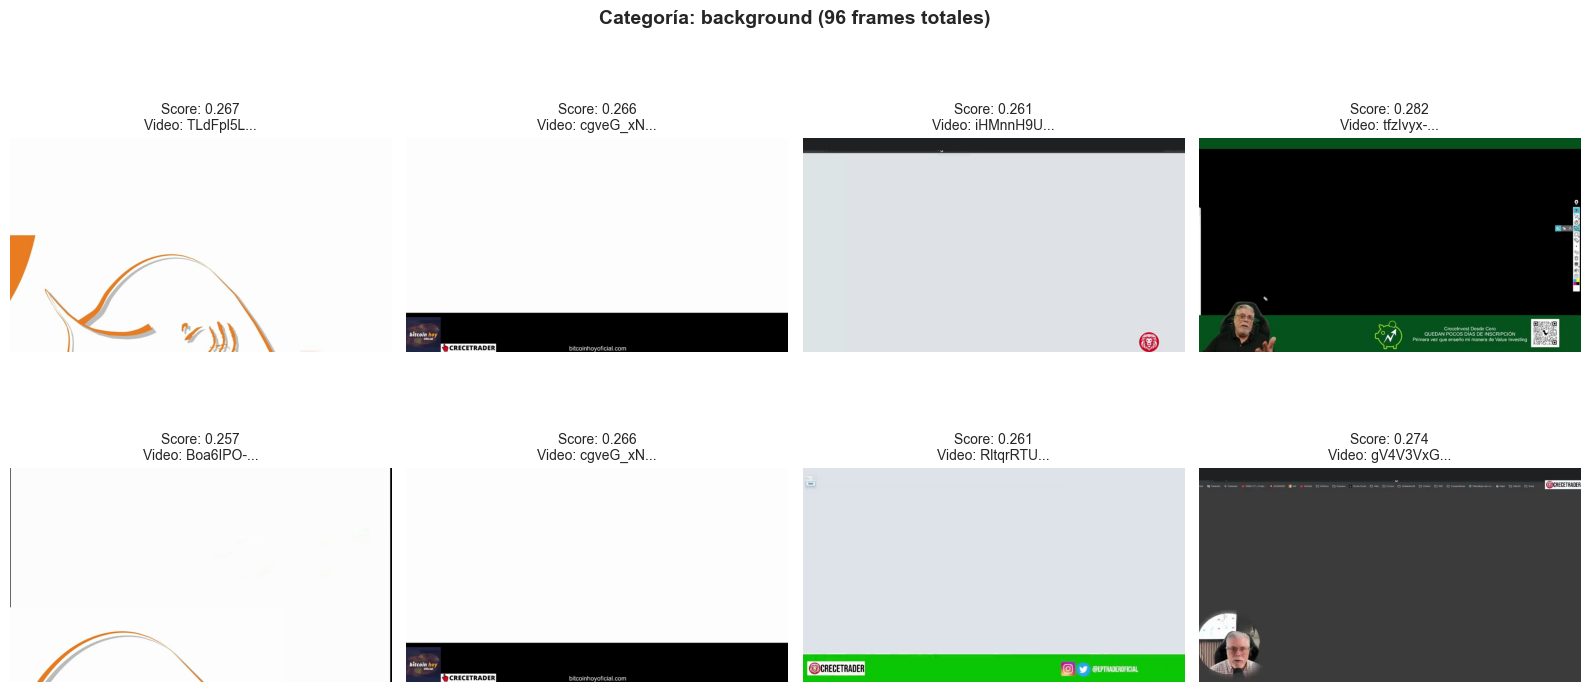

--------------------------------------------------------------------------------

📊 Categoría: other
   Total frames: 24
   Score promedio: 0.233
   Score mínimo: 0.205
   Score máximo: 0.267


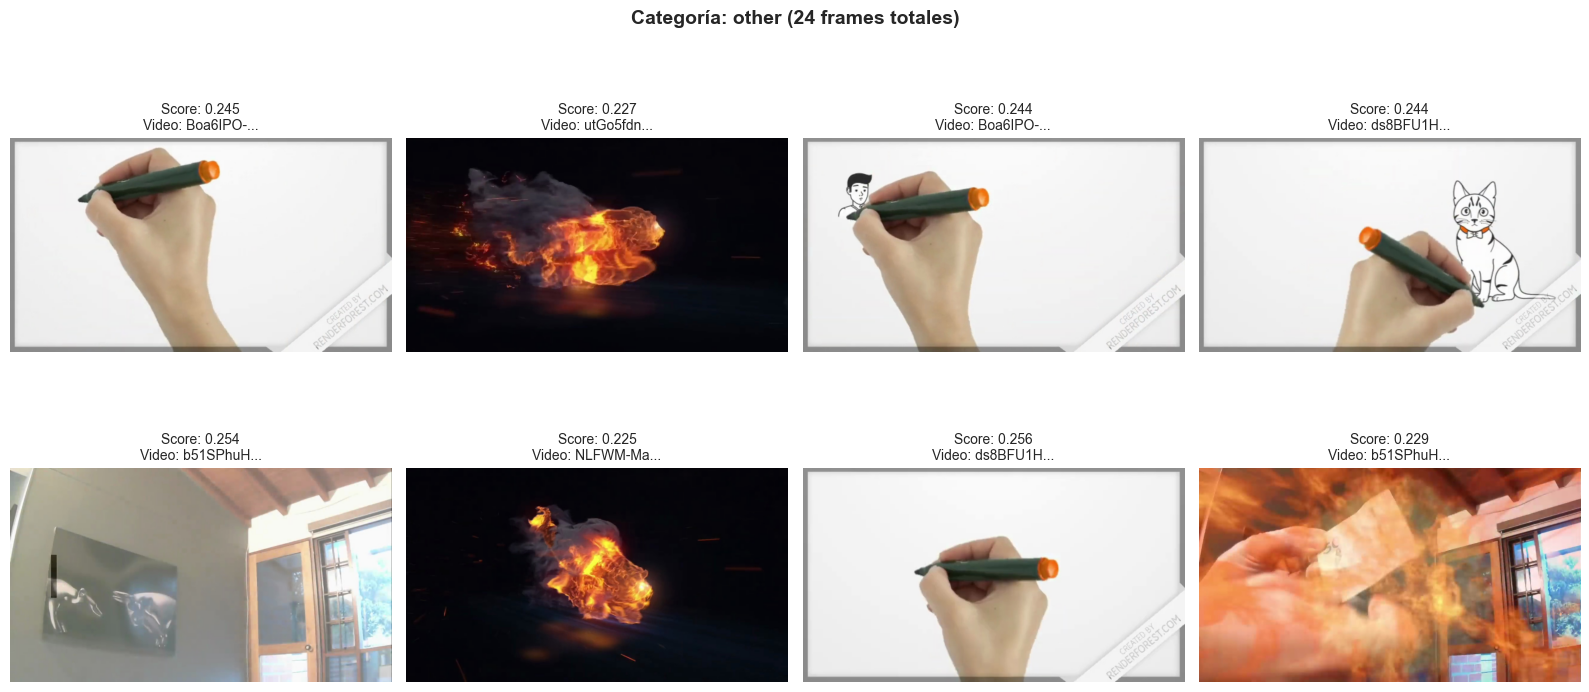

--------------------------------------------------------------------------------


In [25]:
# Visualizar muestras de cada categoría
print("🖼️  Visualizando muestras por categoría...")
print("=" * 80)

# Obtener categorías únicas ordenadas por frecuencia
categories = df_clip['clip_category_code'].value_counts().index.tolist()

# Número de muestras por categoría
N_SAMPLES_PER_CATEGORY = 8

for category_code in categories:
    print(f"\n📊 Categoría: {category_code}")
    print(f"   Total frames: {(df_clip['clip_category_code'] == category_code).sum():,}")
    print(f"   Score promedio: {df_clip[df_clip['clip_category_code'] == category_code]['clip_score'].mean():.3f}")
    print(f"   Score mínimo: {df_clip[df_clip['clip_category_code'] == category_code]['clip_score'].min():.3f}")
    print(f"   Score máximo: {df_clip[df_clip['clip_category_code'] == category_code]['clip_score'].max():.3f}")
    
    # Mostrar muestras
    show_category_samples(df_clip, category_code, n_samples=N_SAMPLES_PER_CATEGORY)
    
    print("-" * 80)


🖼️  Mostrando 16 muestras de la categoría 'candlestick':


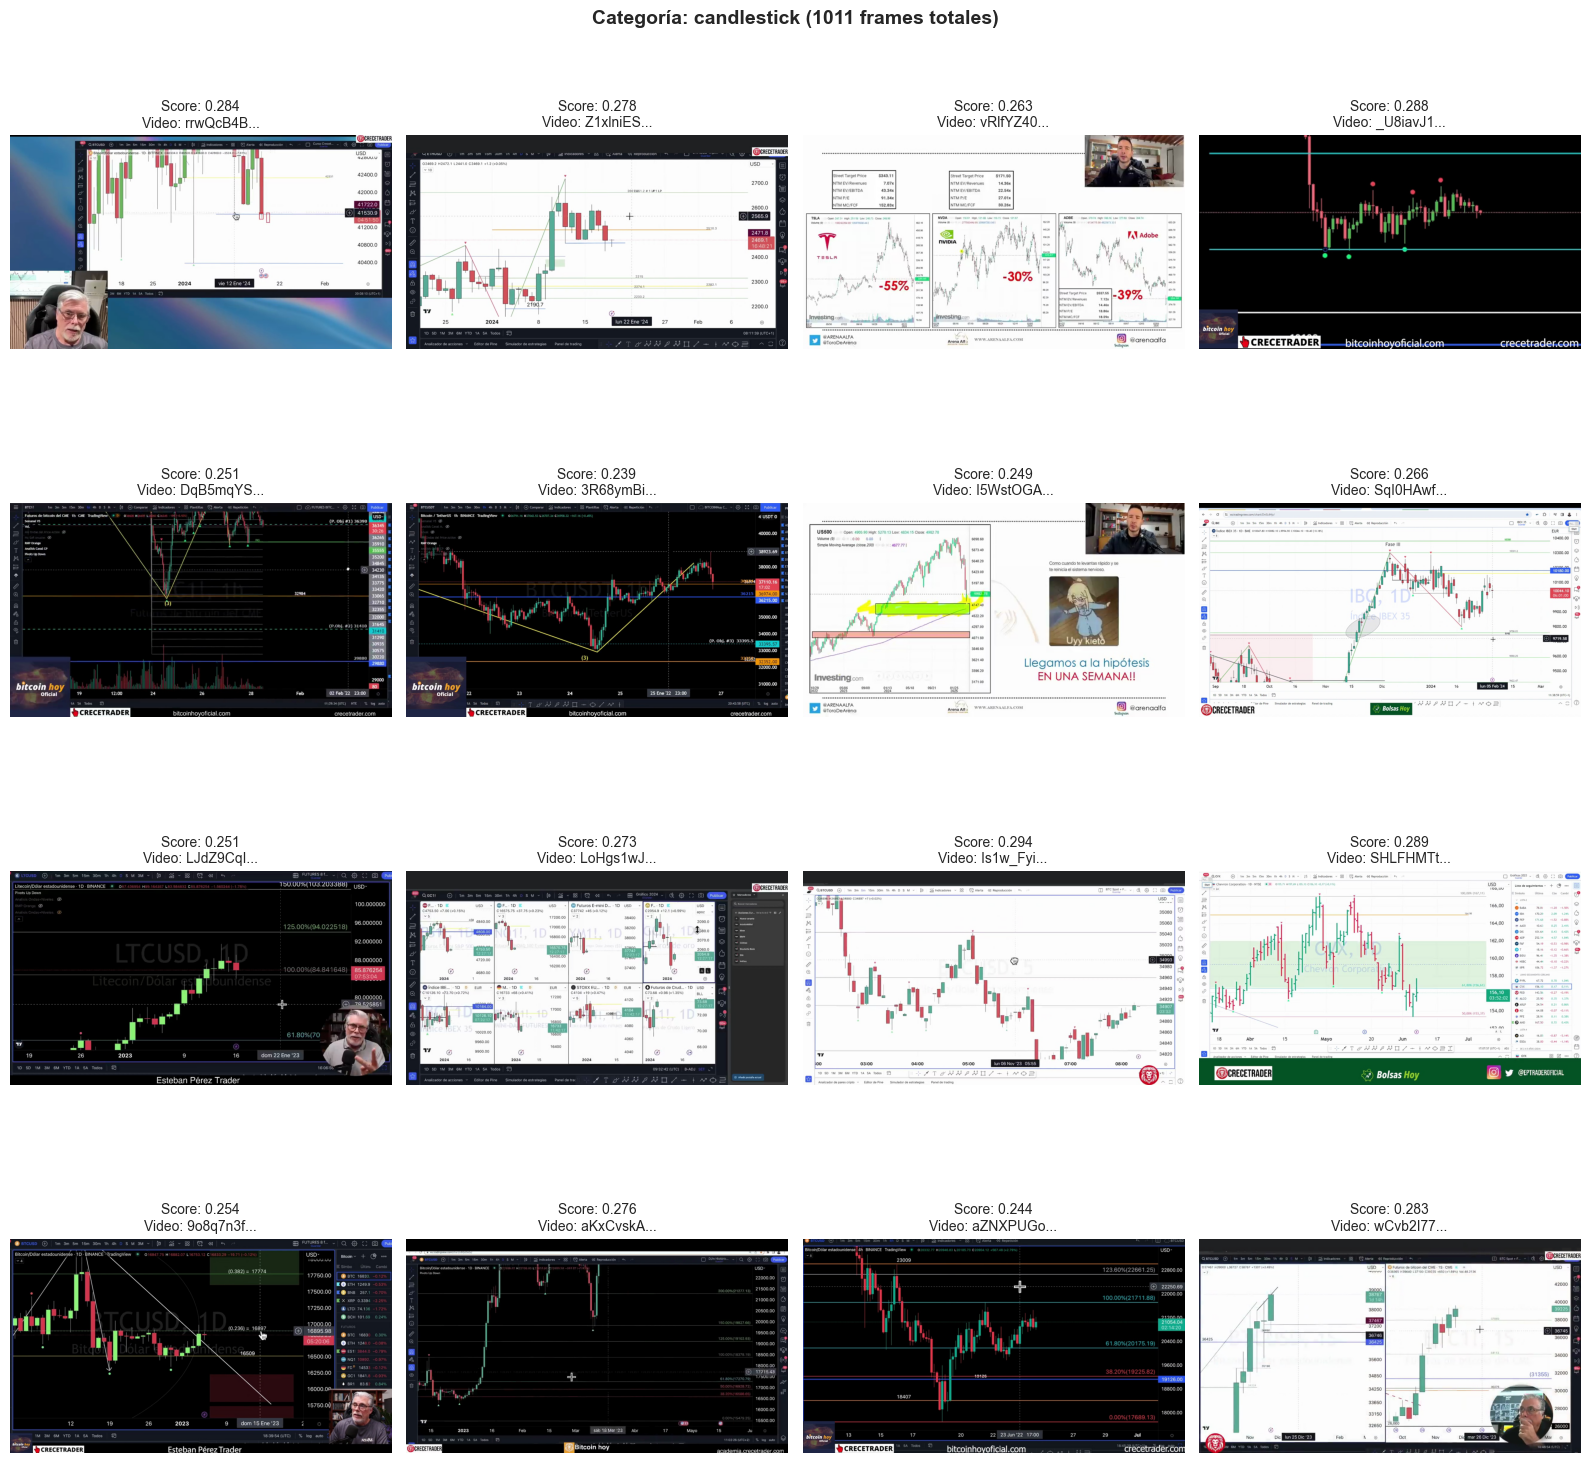

In [26]:
# Cambiar esta variable para ver una categoría específica
CATEGORY_TO_VIEW = "candlestick"  # Cambia según la categoría que quieras ver
N_SAMPLES = 16  # Número de muestras a mostrar

if CATEGORY_TO_VIEW in df_clip['clip_category_code'].values:
    print(f"🖼️  Mostrando {N_SAMPLES} muestras de la categoría '{CATEGORY_TO_VIEW}':")
    show_category_samples(df_clip, CATEGORY_TO_VIEW, n_samples=N_SAMPLES)
else:
    print(f"⚠️  Categoría '{CATEGORY_TO_VIEW}' no encontrada en el dataset.")
    print(f"   Categorías disponibles: {df_clip['clip_category_code'].unique().tolist()}")


## 2. Cargar Embeddings de ResNet50


In [27]:
# Configuración del modelo de embeddings (debe coincidir con el usado en el pipeline)
MODEL_NAME = 'resnet50'  # Debe ser el mismo que se usó en keyframe_extraction_pipeline.ipynb
FEATURES_DIR = f"features_{MODEL_NAME}"

if not os.path.exists(FEATURES_DIR):
    raise FileNotFoundError(
        f"Directorio de features no encontrado: {FEATURES_DIR}\n"
        f"Ejecuta primero el notebook 'keyframe_extraction_pipeline.ipynb' para generar los embeddings."
    )

print(f"✅ Directorio de features encontrado: {FEATURES_DIR}")
print(f"   Modelo: {MODEL_NAME}")


✅ Directorio de features encontrado: features_resnet50
   Modelo: resnet50


In [28]:
# Inicializar feature extractor para cargar embeddings
device = 'cuda' if __import__('torch').cuda.is_available() else 'cpu'
feature_extractor = FeatureExtractor(model_name=MODEL_NAME, device=device, batch_size=32)

print(f"🔧 Feature extractor inicializado: {MODEL_NAME} en {device}")
print(f"   Dimensión de features: {feature_extractor.feature_dim}")


Cargando RESNET50 en cpu...
Modelo RESNET50 cargado exitosamente
Dimensión de features: 2048
🔧 Feature extractor inicializado: resnet50 en cpu
   Dimensión de features: 2048


In [29]:
# Cargar embeddings para cada frame
# Los embeddings están guardados por video, así que los cargamos y mapeamos a frames
print(f"🔄 Cargando embeddings para {len(df_clip):,} frames...")

# Agrupar por video para cargar eficientemente
embeddings_dict = {}  # frame_path -> embedding
missing_embeddings = []

# Obtener lista única de videos
video_ids = df_clip['video_id'].unique()
print(f"   Videos únicos: {len(video_ids)}")

# Cargar embeddings por video
for video_id in tqdm(video_ids, desc="Cargando embeddings"):
    features_path = os.path.join(FEATURES_DIR, f"{video_id}_features.pkl")
    
    if not os.path.exists(features_path):
        # Frames de este video sin embeddings
        video_frames = df_clip[df_clip['video_id'] == video_id]['frame_path'].tolist()
        missing_embeddings.extend(video_frames)
        continue
    
    # Cargar features del video
    try:
        features, valid_paths, metadata = feature_extractor.load_features(features_path)
        
        # Mapear cada frame a su embedding
        for idx, path in enumerate(valid_paths):
            # Resolver rutas relativas/absolutas
            path_normalized = os.path.normpath(path)
            embeddings_dict[path_normalized] = features[idx]
    except Exception as e:
        print(f"⚠️  Error cargando features para video {video_id}: {e}")
        continue

print(f"\n✅ Embeddings cargados:")
print(f"   Frames con embeddings: {len(embeddings_dict):,}")
if missing_embeddings:
    print(f"   Frames sin embeddings: {len(missing_embeddings):,}")


🔄 Cargando embeddings para 3,669 frames...
   Videos únicos: 825


Cargando embeddings: 100%|██████████| 825/825 [00:00<00:00, 1211.22it/s]


✅ Embeddings cargados:
   Frames con embeddings: 195,495


In [30]:
# Combinar embeddings con etiquetas CLIP
print(f"🔄 Combinando embeddings con etiquetas CLIP...")

# Normalizar rutas en df_clip para hacer match
df_clip['frame_path_normalized'] = df_clip['frame_path'].apply(lambda x: os.path.normpath(x) if pd.notna(x) else None)

# Filtrar frames que tienen embeddings
df_clip['has_embedding'] = df_clip['frame_path_normalized'].isin(embeddings_dict.keys())
df_with_embeddings = df_clip[df_clip['has_embedding']].copy()

print(f"✅ Frames con embeddings y etiquetas: {len(df_with_embeddings):,}")
print(f"   Frames descartados (sin embeddings): {len(df_clip) - len(df_with_embeddings):,}")

# Verificar que todas las categorías están presentes
print(f"\n📊 Distribución de categorías en dataset final:")
category_counts = df_with_embeddings['clip_category_code'].value_counts()
for cat, count in category_counts.items():
    pct = count / len(df_with_embeddings) * 100
    print(f"   {cat:15s}: {count:6,} frames ({pct:5.2f}%)")


🔄 Combinando embeddings con etiquetas CLIP...
✅ Frames con embeddings y etiquetas: 3,669
   Frames descartados (sin embeddings): 0

📊 Distribución de categorías en dataset final:
   candlestick    :  1,011 frames (27.56%)
   person         :    698 frames (19.02%)
   line_chart     :    443 frames (12.07%)
   table          :    398 frames (10.85%)
   text           :    365 frames ( 9.95%)
   logo           :    180 frames ( 4.91%)
   screenshot     :    170 frames ( 4.63%)
   bar_chart      :    166 frames ( 4.52%)
   diagram        :    118 frames ( 3.22%)
   background     :     96 frames ( 2.62%)
   other          :     24 frames ( 0.65%)


## 3. Preparar Dataset para Entrenamiento


In [31]:
# Crear matriz de features (embeddings) y vector de labels (categorías CLIP)
print(f"🔄 Preparando dataset para entrenamiento...")

# Extraer embeddings en orden del DataFrame
X = []
y = []
valid_indices = []

for idx, row in tqdm(df_with_embeddings.iterrows(), total=len(df_with_embeddings), desc="Extrayendo features"):
    frame_path_norm = row['frame_path_normalized']
    category_code = row['clip_category_code']
    
    if frame_path_norm in embeddings_dict and pd.notna(category_code):
        embedding = embeddings_dict[frame_path_norm]
        X.append(embedding)
        y.append(category_code)
        valid_indices.append(idx)

X = np.array(X)
y = np.array(y)

print(f"\n✅ Dataset preparado:")
print(f"   Features shape: {X.shape}")
print(f"   Labels shape: {y.shape}")
print(f"   Clases únicas: {len(np.unique(y))}")
print(f"   Distribución de clases:")
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    pct = count / len(y) * 100
    print(f"      {label:15s}: {count:6,} ({pct:5.2f}%)")


🔄 Preparando dataset para entrenamiento...


Extrayendo features: 100%|██████████| 3669/3669 [00:00<00:00, 52624.58it/s]


✅ Dataset preparado:
   Features shape: (3669, 2048)
   Labels shape: (3669,)
   Clases únicas: 11
   Distribución de clases:
      background     :     96 ( 2.62%)
      bar_chart      :    166 ( 4.52%)
      candlestick    :  1,011 (27.56%)
      diagram        :    118 ( 3.22%)
      line_chart     :    443 (12.07%)
      logo           :    180 ( 4.91%)
      other          :     24 ( 0.65%)
      person         :    698 (19.02%)
      screenshot     :    170 ( 4.63%)
      table          :    398 (10.85%)
      text           :    365 ( 9.95%)


In [32]:
# Crear DataFrame con features (una columna por dimensión del embedding)
feature_cols = [f'feature_{i}' for i in range(X.shape[1])]
df_train = pd.DataFrame(X, columns=feature_cols)
df_train['class'] = y  # Usar 'class' como nombre de columna para compatibilidad con AutoGluon

print(f"✅ DataFrame creado:")
print(f"   Shape: {df_train.shape}")
print(f"   Columnas: {len(df_train.columns)} (features + class)")
print(f"\nPrimeras filas:")
df_train.head()


✅ DataFrame creado:
   Shape: (3669, 2049)
   Columnas: 2049 (features + class)

Primeras filas:


feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.000000   0.000000   0.149320   0.000000   0.214719        0.0   
1   0.042633   0.055051   0.574033   0.057309   0.206375        0.0   
2   0.000000   0.001787   0.047362   0.000000   0.008950        0.0   
3   0.047122   0.039054   0.081216   0.000000   0.016559        0.0   
4   0.000000   0.000000   0.000000   0.000000   0.000000        0.0   

   feature_6  feature_7  feature_8  feature_9  ...  feature_2039  \
0   0.000000   0.000000   0.000000   0.000000  ...      0.008871   
1   0.055387   1.042637   0.000000   0.001253  ...      0.378534   
2   0.000000   1.271636   0.249519   0.000000  ...      0.000025   
3   0.000000   0.004430   0.000000   0.000000  ...      0.419543   
4   0.000000   0.000000   0.000000   0.000000  ...      0.000000   

   feature_2040  feature_2041  feature_2042  feature_2043  feature_2044  \
0      0.070771      0.243422           0.0      0.015067           0.0   
1      0.000000      0.012971           0.0      0.188805           0.0   
2      0.053843      0.116341           0.0      0.236366           0.0   
3      0.515722      0.000000           0.0      0.000000           0.0   
4      0.000000      0.019655           0.0      0.000000           0.0   

   feature_2045  feature_2046  feature_2047        class  
0      0.026104      0.000000      0.000000  candlestick  
1      0.359492      0.089845      0.000000       person  
2      0.000000      0.142466      0.022955       person  
3      0.000734      0.000000      0.000000      diagram  
4      0.052449      0.000000      0.000000  candlestick  

[5 rows x 2049 columns]

In [45]:
# Dividir en train/test
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Usar stratify para mantener distribución de clases
df_train_split, df_test_split = train_test_split(
    df_train,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_train['class']
)

print(f"✅ Dataset dividido:")
print(f"   Train: {len(df_train_split):,} muestras ({len(df_train_split)/len(df_train)*100:.1f}%)")
print(f"   Test: {len(df_test_split):,} muestras ({len(df_test_split)/len(df_train)*100:.1f}%)")

print(f"\n📊 Distribución de clases en train:")
train_dist = df_train_split['class'].value_counts()
for cat, count in train_dist.items():
    pct = count / len(df_train_split) * 100
    print(f"   {cat:15s}: {count:6,} ({pct:5.2f}%)")

print(f"\n📊 Distribución de clases en test:")
test_dist = df_test_split['class'].value_counts()
for cat, count in test_dist.items():
    pct = count / len(df_test_split) * 100
    print(f"   {cat:15s}: {count:6,} ({pct:5.2f}%)")


✅ Dataset dividido:
   Train: 2,935 muestras (80.0%)
   Test: 734 muestras (20.0%)

📊 Distribución de clases en train:
   candlestick    :    809 (27.56%)
   person         :    558 (19.01%)
   line_chart     :    354 (12.06%)
   table          :    318 (10.83%)
   text           :    292 ( 9.95%)
   logo           :    144 ( 4.91%)
   screenshot     :    136 ( 4.63%)
   bar_chart      :    133 ( 4.53%)
   diagram        :     95 ( 3.24%)
   background     :     77 ( 2.62%)
   other          :     19 ( 0.65%)

📊 Distribución de clases en test:
   candlestick    :    202 (27.52%)
   person         :    140 (19.07%)
   line_chart     :     89 (12.13%)
   table          :     80 (10.90%)
   text           :     73 ( 9.95%)
   logo           :     36 ( 4.90%)
   screenshot     :     34 ( 4.63%)
   bar_chart      :     33 ( 4.50%)
   diagram        :     23 ( 3.13%)
   background     :     19 ( 2.59%)
   other          :      5 ( 0.68%)


## 4. Entrenar Clasificador con AutoGluon


In [52]:
# Configurar datos para clasificación
def train_classifier(df_train, df_test, model_name, target_column='class', time_limit=300):
    """
    Entrena un clasificador usando AutoGluon
    
    Args:
        df_train: DataFrame de entrenamiento con features y target
        df_test: DataFrame de test con features y target
        model_name: Nombre del modelo (para guardar)
        target_column: Nombre de la columna target
        time_limit: Tiempo límite de entrenamiento en segundos
    """
    print(f"\n🎯 Entrenando clasificador {model_name} para {target_column}")
    
    # Preparar características (excluir columnas no numéricas)
    feature_cols = [col for col in df_train.columns if col.startswith('feature_')]
    
    print(f"  • Características: {len(feature_cols)}")
    print(f"  • Train: {len(df_train)} muestras")
    print(f"  • Test: {len(df_test)} muestras")
    print(f"  • Clases: {df_train[target_column].nunique()}")
    
    # Crear DataFrame para AutoGluon 
    train_data = df_train[feature_cols + [target_column]].copy()
    test_data = df_test[feature_cols + [target_column]].copy()
    
    # Configurar predictor con métricas apropiadas para dataset desbalanceado
    predictor = TabularPredictor(
        label=target_column,
        problem_type='multiclass',
        eval_metric='f1_weighted',  # F1 weighted para manejar desbalanceo
        path=f'./models/{model_name}_{target_column}'
    )
    
    # Entrenar modelo
    print(f"🔄 Entrenando {model_name}...")
    predictor.fit(
        train_data,
        time_limit=time_limit,  # Tiempo límite (ajusta según necesites)
        presets='best_quality',  # Usar mejor calidad
        verbosity=2
    )
    
    # Hacer predicciones
    print(f"🔮 Haciendo predicciones...")
    predictions = predictor.predict(test_data)
    probabilities = predictor.predict_proba(test_data)
    
    # Evaluar modelo
    print(f"📊 Evaluando modelo...")
    metrics = predictor.evaluate(test_data, silent=True)
    # Extraer el valor de accuracy del diccionario de métricas
    accuracy = metrics.get('accuracy', metrics.get('f1_weighted', 0.0))
    
    return predictor, predictions, probabilities, accuracy

# Entrenar clasificador
TIME_LIMIT = 1800#600  # 10 minutos (ajusta según necesites)
MODEL_NAME_CLASSIFIER = f"classifier_{MODEL_NAME}"

predictor, predictions, probabilities, accuracy = train_classifier(
    df_train_split, 
    df_test_split, 
    MODEL_NAME_CLASSIFIER, 
    target_column='class',
    time_limit=TIME_LIMIT
)

print(f"\n✅ Modelo entrenado:")
print(f"   Accuracy: {accuracy}")

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.4
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.6.0: Mon Jul 14 11:28:30 PDT 2025; root:xnu-11417.140.69~1/RELEASE_ARM64_T6030
CPU Count:          11
Memory Avail:       20.48 GB / 36.00 GB (56.9%)
Disk Space Avail:   10.85 GB / 460.43 GB (2.4%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. 


🎯 Entrenando clasificador classifier_resnet50 para class
  • Características: 2048
  • Train: 2935 muestras
  • Test: 734 muestras
  • Clases: 11
🔄 Entrenando classifier_resnet50...


Leaderboard on holdout data (DyStack):
                      model  score_holdout  score_val  eval_metric  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0    NeuralNetFastAI_BAG_L1       0.941357   0.934121  f1_weighted        0.550451       0.127713    7.008287                 0.550451                0.127713           7.008287            1       True          1
1    NeuralNetFastAI_BAG_L2       0.932323   0.937005  f1_weighted        1.416102       2.589836  289.684243                 0.101970                0.108110           7.557120            2       True          9
2           LightGBM_BAG_L2       0.925627   0.942194  f1_weighted        1.367118       2.583551  302.289878                 0.052986                0.101825          20.162755            2       True         11
3       WeightedEnsemble_L2       0.925286   0.940894  f1_weighted        1.278256       1.962446  280.435478

🔮 Haciendo predicciones...
📊 Evaluando modelo...

✅ Modelo entrenado:
   Accuracy: 0.94141689373297


## 5. Evaluación Detallada


In [58]:
# Reporte de clasificación detallado
y_true = df_test_split['class'].values
y_pred = predictions.values if hasattr(predictions, 'values') else predictions

print("📊 REPORTE DE CLASIFICACIÓN:")
print("=" * 80)
print(classification_report(y_true, y_pred))

# Matriz de confusión
print("\n📊 MATRIZ DE CONFUSIÓN:")
print("=" * 80)
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
cm_df


📊 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

  background       0.95      1.00      0.97        19
   bar_chart       0.93      0.85      0.89        33
 candlestick       0.94      0.98      0.96       202
     diagram       0.94      0.74      0.83        23
  line_chart       0.86      0.89      0.87        89
        logo       1.00      0.94      0.97        36
       other       0.67      0.40      0.50         5
      person       0.98      1.00      0.99       140
  screenshot       1.00      0.79      0.89        34
       table       0.96      0.99      0.98        80
        text       0.91      0.95      0.93        73

    accuracy                           0.94       734
   macro avg       0.92      0.87      0.89       734
weighted avg       0.94      0.94      0.94       734


📊 MATRIZ DE CONFUSIÓN:


background  bar_chart  candlestick  diagram  line_chart  logo  \
background           19          0            0        0           0     0   
bar_chart             0         28            1        0           3     0   
candlestick           0          0          197        0           5     0   
diagram               0          1            0       17           2     0   
line_chart            0          0            9        0          79     0   
logo                  1          0            0        1           0    34   
other                 0          0            0        0           1     0   
person                0          0            0        0           0     0   
screenshot            0          1            2        0           1     0   
table                 0          0            0        0           1     0   
text                  0          0            0        0           0     0   

             other  person  screenshot  table  text  
background       0       0           0      0     0  
bar_chart        0       0           0      0     1  
candlestick      0       0           0      0     0  
diagram          0       0           0      0     3  
line_chart       0       0           0      1     0  
logo             0       0           0      0     0  
other            2       2           0      0     0  
person           0     140           0      0     0  
screenshot       0       0          27      0     3  
table            0       0           0     79     0  
text             1       1           0      2    69

📊 Gráfico guardado en images/confusion_matrix_classifier_resnet50.png


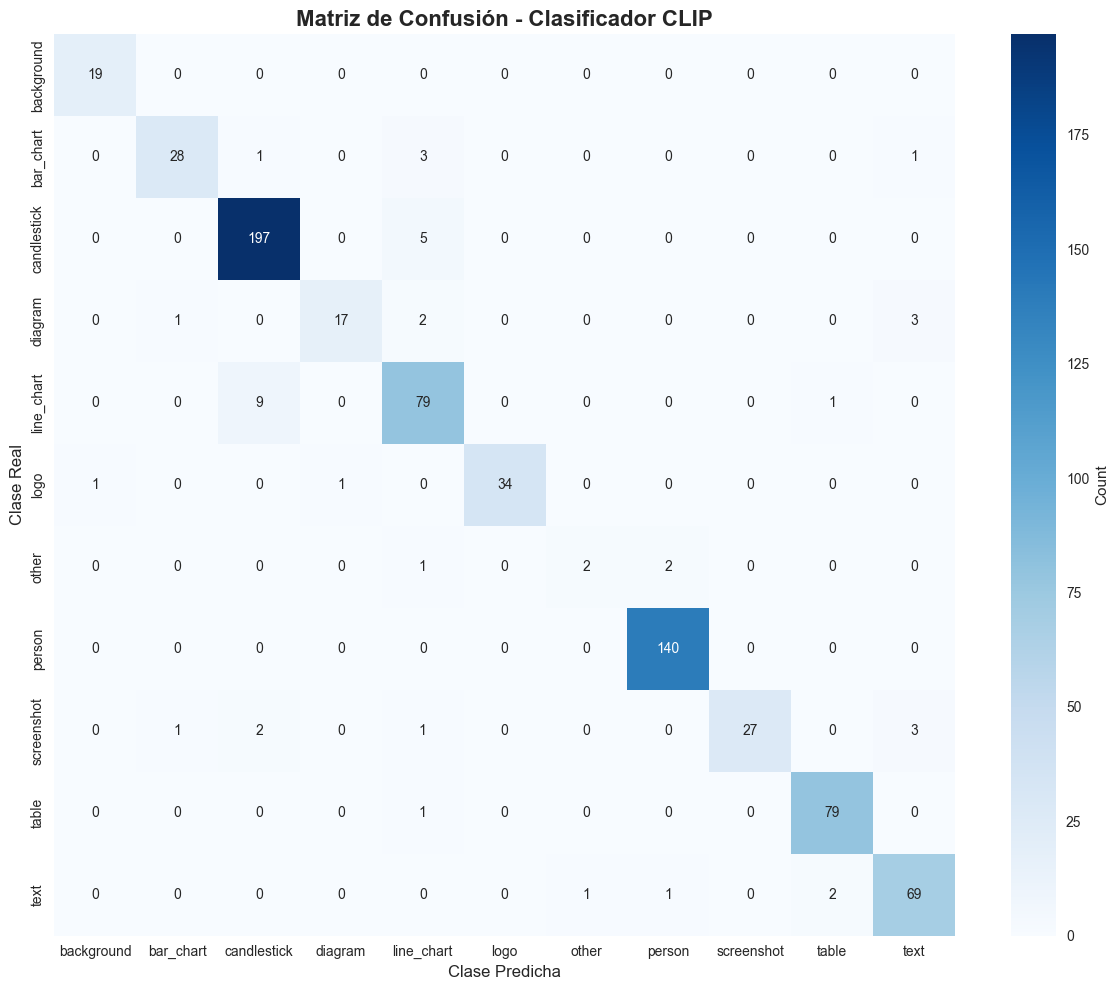

In [59]:
# Visualizar matriz de confusión
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.title('Matriz de Confusión - Clasificador CLIP', fontsize=16, fontweight='bold')
plt.ylabel('Clase Real', fontsize=12)
plt.xlabel('Clase Predicha', fontsize=12)
plt.tight_layout()

# Guardar gráfico
os.makedirs('images', exist_ok=True)
plt.savefig(f'images/confusion_matrix_{MODEL_NAME_CLASSIFIER}.png', dpi=300, bbox_inches='tight')
print(f"📊 Gráfico guardado en images/confusion_matrix_{MODEL_NAME_CLASSIFIER}.png")
plt.show()


📊 ANÁLISIS DE ERRORES POR CLASE:
             total  correct  errors  accuracy
other          5.0      2.0     3.0  0.400000
diagram       23.0     17.0     6.0  0.739130
screenshot    34.0     27.0     7.0  0.794118
bar_chart     33.0     28.0     5.0  0.848485
line_chart    89.0     79.0    10.0  0.887640
logo          36.0     34.0     2.0  0.944444
text          73.0     69.0     4.0  0.945205
candlestick  202.0    197.0     5.0  0.975248
table         80.0     79.0     1.0  0.987500
background    19.0     19.0     0.0  1.000000
person       140.0    140.0     0.0  1.000000

📊 Gráfico guardado en images/accuracy_by_class_classifier_resnet50.png


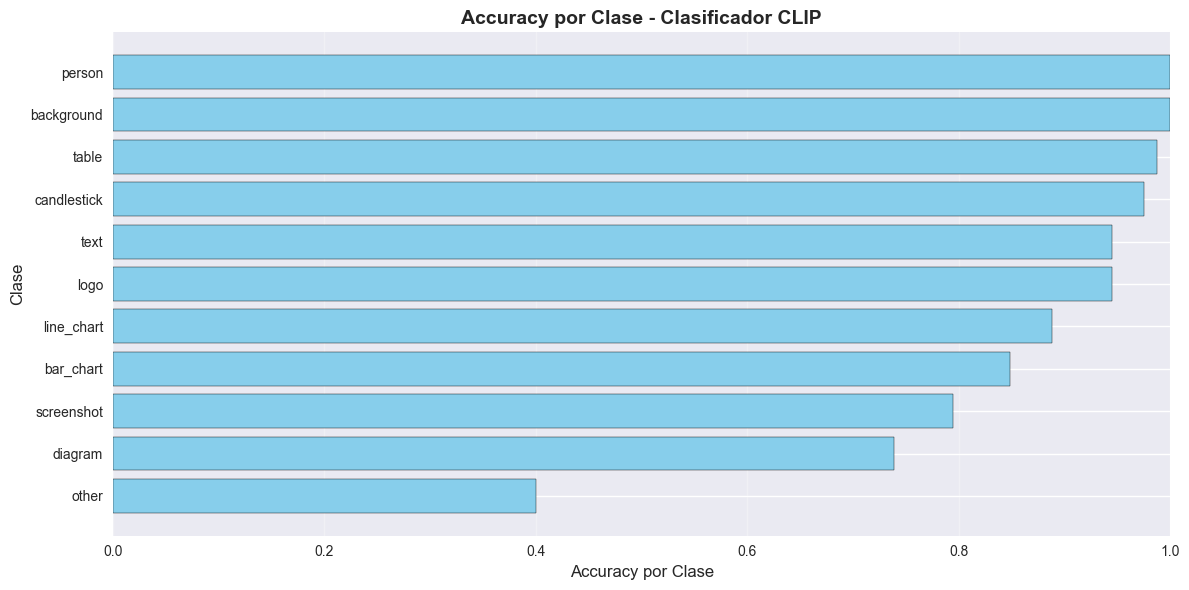

In [60]:
# Análisis de errores por clase
print("📊 ANÁLISIS DE ERRORES POR CLASE:")
print("=" * 80)

errors_by_class = {}
for true_class in np.unique(y_true):
    mask = y_true == true_class
    pred_for_class = y_pred[mask]
    correct = (pred_for_class == true_class).sum()
    total = mask.sum()
    accuracy_class = correct / total if total > 0 else 0
    errors_by_class[true_class] = {
        'total': total,
        'correct': correct,
        'errors': total - correct,
        'accuracy': accuracy_class
    }

# Crear DataFrame para visualización
errors_df = pd.DataFrame(errors_by_class).T
errors_df = errors_df.sort_values('accuracy', ascending=True)

print(errors_df.to_string())

# Visualizar
plt.figure(figsize=(12, 6))
plt.barh(errors_df.index, errors_df['accuracy'], color='skyblue', edgecolor='black')
plt.xlabel('Accuracy por Clase', fontsize=12)
plt.ylabel('Clase', fontsize=12)
plt.title('Accuracy por Clase - Clasificador CLIP', fontsize=14, fontweight='bold')
plt.xlim([0, 1])
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

plt.savefig(f'images/accuracy_by_class_{MODEL_NAME_CLASSIFIER}.png', dpi=300, bbox_inches='tight')
print(f"\n📊 Gráfico guardado en images/accuracy_by_class_{MODEL_NAME_CLASSIFIER}.png")
plt.show()


## 6. Guardar Modelo y Resultados


In [61]:
# El modelo ya fue guardado automáticamente por AutoGluon
model_path = f'./models/{MODEL_NAME_CLASSIFIER}_class'
print(f"✅ Modelo guardado en: {model_path}")

# Guardar información del modelo
import json

model_info = {
    'model_name': MODEL_NAME_CLASSIFIER,
    'embedding_model': MODEL_NAME,
    'feature_dim': X.shape[1],
    'n_classes': len(np.unique(y)),
    'n_train': len(df_train_split),
    'n_test': len(df_test_split),
    'accuracy': float(accuracy) if isinstance(accuracy, (int, float, np.number)) else float(accuracy.get('accuracy', 0.0)) if isinstance(accuracy, dict) else 0.0,
    'classes': list(np.unique(y)),
    'time_limit': TIME_LIMIT
}

info_path = f'./models/{MODEL_NAME_CLASSIFIER}_class_info.json'
with open(info_path, 'w') as f:
    json.dump(model_info, f, indent=2)

print(f"✅ Información del modelo guardada en: {info_path}")
print(f"\n📋 Información del modelo:")
for key, value in model_info.items():
    print(f"   {key}: {value}")


✅ Modelo guardado en: ./models/classifier_resnet50_class
✅ Información del modelo guardada en: ./models/classifier_resnet50_class_info.json

📋 Información del modelo:
   model_name: classifier_resnet50
   embedding_model: resnet50
   feature_dim: 2048
   n_classes: 11
   n_train: 2935
   n_test: 734
   accuracy: 0.94141689373297
   classes: [np.str_('background'), np.str_('bar_chart'), np.str_('candlestick'), np.str_('diagram'), np.str_('line_chart'), np.str_('logo'), np.str_('other'), np.str_('person'), np.str_('screenshot'), np.str_('table'), np.str_('text')]
   time_limit: 1800


## 7. Resumen Final


In [62]:
print("=" * 80)
print("📊 RESUMEN FINAL")
print("=" * 80)
print(f"\n✅ Clasificador entrenado exitosamente")
print(f"\n📈 Métricas:")
print(f"   • Accuracy: {accuracy}")
print(f"   • Clases: {len(np.unique(y))}")
print(f"   • Features: {X.shape[1]}")
print(f"\n📁 Archivos generados:")
print(f"   • Modelo: {model_path}")
print(f"   • Info: {info_path}")
print(f"   • Confusion matrix: images/confusion_matrix_{MODEL_NAME_CLASSIFIER}.png")
print(f"   • Accuracy by class: images/accuracy_by_class_{MODEL_NAME_CLASSIFIER}.png")


📊 RESUMEN FINAL

✅ Clasificador entrenado exitosamente

📈 Métricas:
   • Accuracy: 0.94141689373297
   • Clases: 11
   • Features: 2048

📁 Archivos generados:
   • Modelo: ./models/classifier_resnet50_class
   • Info: ./models/classifier_resnet50_class_info.json
   • Confusion matrix: images/confusion_matrix_classifier_resnet50.png
   • Accuracy by class: images/accuracy_by_class_classifier_resnet50.png
